# Pave SFM with Python

![](toy.png)

## relevant libs

In [330]:
# SURF and SIFT is only supported in older version
# pip install opencv-contrib-python==3.4.2.16
# pip install opencv-python==3.4.2.16
import numpy as np
import glob,os,sys
import cv2 as cv 
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import json
import pickle
from scipy.sparse import lil_matrix
import time
from scipy.optimize import least_squares
import plotly.graph_objects as go

## load data

In [147]:
image_dir='./matlab-code/data/images/*.png'
files=glob.glob(image_dir)
print('%d images founded' % len(files))

11 images founded


In [148]:
'''
load images as gray images
'''
def read_image(path,ratio=1):
    img=cv.imread(path,0)
    dim=(int(img.shape[1]*ratio),int(img.shape[0]*ratio))
    resized=cv.resize(img,dim)
    return resized

In [149]:
images=[]
for eachimage in files:
    img=read_image(eachimage)
    images.append(img)
print(images[0].shape)

(2048, 3072)


In [150]:
# get calibration matrix
path='matlab-code/data/k/K.txt'
f=open(path,'r')
lines=f.readlines()
K=np.zeros((3,3))
for i in range(3):
    for j in range(3):
        K[i,j]=float(lines[i].split(' ')[j])
print(K)

[[2.75948e+03 0.00000e+00 1.52069e+03]
 [0.00000e+00 2.76416e+03 1.00681e+03]
 [0.00000e+00 0.00000e+00 1.00000e+00]]


## extract features using SURF

### play with SURF on a single image

In [6]:
# Here I set Hessian Threshold to 400
surf = cv.xfeatures2d.SURF_create(400)
sample_img=images[0]
%time kp, des = surf.detectAndCompute(sample_img,None)
print(len(kp))

CPU times: user 4.78 s, sys: 247 ms, total: 5.03 s
Wall time: 2.22 s
8136


In [7]:
kp[0]

<KeyPoint 0x120107900>

In [8]:
des.shape

(8136, 64)

In [9]:
# Here I set Hessian Threshold to 1000
# extended: true - use extended 128-element descriptors; false - use 64-element descriptors
surf = cv.xfeatures2d.SURF_create(hessianThreshold=600,extended=True)
sample_img=images[0]
kp, des = surf.detectAndCompute(sample_img,None)
print(len(kp))

5025


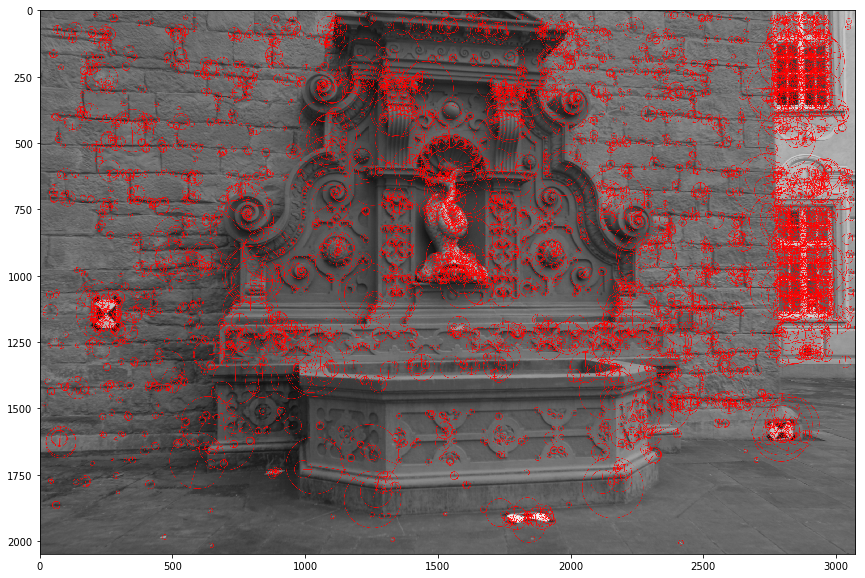

In [10]:
img2 = cv.drawKeypoints(sample_img,kp,None,(255,0,0),4)
plt.figure(figsize=(20,10))
plt.imshow(img2)

In [11]:
print(len(kp),des.shape)

5025 (5025, 128)


### compute keypoints and descriptors for all the images

In [151]:
keypoints,descriptors=[],[]
surf = cv.xfeatures2d.SURF_create(hessianThreshold=800,extended=True)
print('---------numbers of keypoints----------')
for image in images:
    kp, des = surf.detectAndCompute(image,None)
    print(len(kp))
    keypoints.append(kp)
    descriptors.append(des)

---------numbers of keypoints----------
3445
2950
2443
2736
5192
2251
2484
2757
2453
4778
3815


<font color='red'> This part could be optimized using multi-processing

## match keypoints

### play with paired images first

In [19]:
# default brute force matcher with ratio test
bf = cv.BFMatcher()
img1,img2=images[0],images[1]
des1,des2=descriptors[0],descriptors[1]
kp1,kp2=keypoints[0],keypoints[1]
matches = bf.knnMatch(des1,des2,k=2)

In [20]:
print(len(matches),len(matches[0]))

5025 2


The result of matches = bf.match(des1,des2) line is a list of DMatch objects. This DMatch object has following attributes:

- DMatch.distance - Distance between descriptors. The lower, the better it is.
- DMatch.trainIdx - Index of the descriptor in train descriptors
- DMatch.queryIdx - Index of the descriptor in query descriptors
- DMatch.imgIdx - Index of the train image.

1326


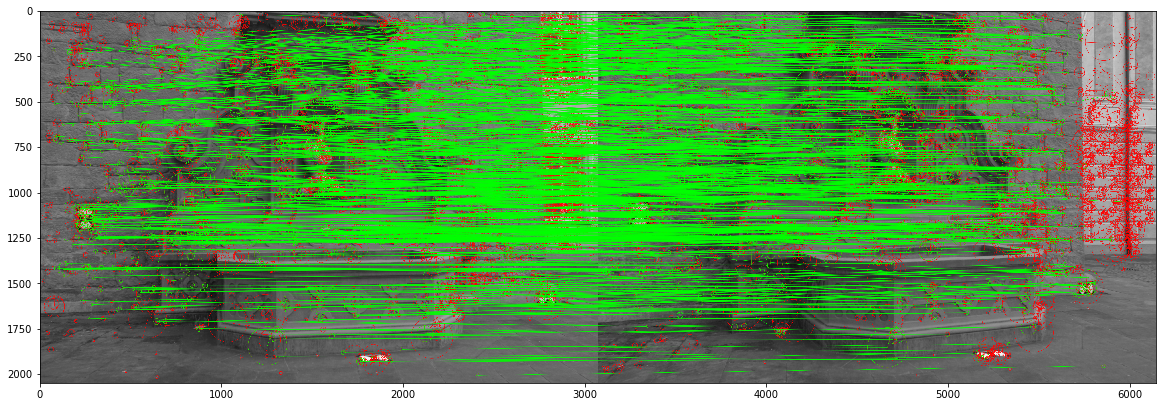

In [32]:
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
print(len(good))
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=4,matchColor = (0,255,0),singlePointColor = (255,0,0))
plt.figure(figsize=(20,10))
plt.imshow(img3)

### compute feature matches for all images

In [152]:
def get_good_matches(descriptors,threshold=0.75):
    bf = cv.BFMatcher()  # Brute Force knn matcher
    n_images=len(descriptors)
    n_good_matches=np.zeros((n_images,n_images)) # store # of good matches between image_i and image_j
    good_matches=[[] for i in range(n_images)] # 2D list
    for i in range(n_images):
        for j in range(n_images):
            if(i!=j):
                des1,des2=descriptors[i],descriptors[j]  # des1——query index; des2 —— train index
                matches = bf.knnMatch(des1,des2,k=2)# find the best and second best match
                good = []
                for m,n in matches:
                    if m.distance < threshold*n.distance:
                        good.append(m)
                n_good_matches[i,j]=len(good)
                good_matches[i].append(good)
            else:
                good_matches[i].append([])
    
    return n_good_matches,good_matches

In [153]:
%time n_good_matches, good_matches=get_good_matches(descriptors)

CPU times: user 1min 43s, sys: 630 ms, total: 1min 43s
Wall time: 33.6 s


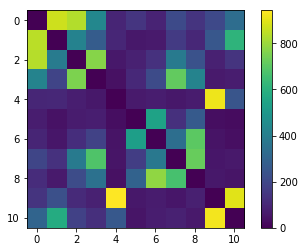

In [154]:
plt.imshow(n_good_matches)
plt.colorbar()

<font color='red'> not necessarily symmetric

## Determine initial pairs

In [155]:
ind = np.unravel_index(np.argmax(n_good_matches, axis=None), n_good_matches.shape)
ind_img1,ind_img2=ind[0],ind[1]
print(ind_img1,ind_img2)

9 4


In [156]:
img1,img2=images[ind_img1],images[ind_img2]
good_match=good_matches[ind_img1][ind_img2]

In [161]:
pts1,pts2=[],[]
for ele in good_match:
    pts1.append(keypoints[ind_img1][ele.queryIdx].pt)
    pts2.append(keypoints[ind_img2][ele.trainIdx].pt)

## two-view geometry

In [162]:
# compute F
pts1=np.int32(pts1)
pts2=np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_RANSAC)

In [163]:
F

array([[ 7.51567634e-09, -2.44195111e-07,  3.33994366e-04],
       [ 8.96588395e-07, -1.03066902e-07,  7.04576815e-03],
       [-1.06459996e-03, -8.16711995e-03,  1.00000000e+00]])

In [164]:
print(pts1.shape,pts2.shape)

(943, 2) (943, 2)


In [165]:
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [166]:
print(pts1.shape,pts2.shape)

(743, 2) (743, 2)


In [167]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

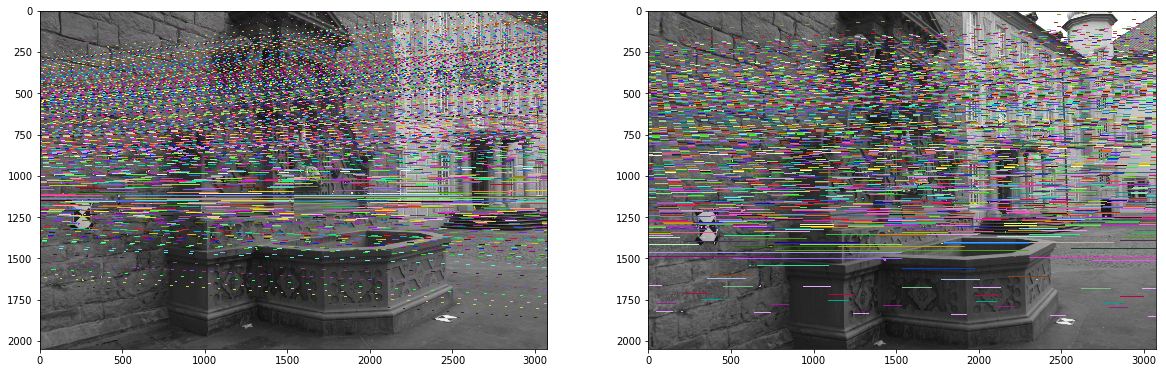

In [168]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

In [190]:
# linear triangulation
def linearTriangulation(P1,x1s,P2,x2s):
    '''
    Given two projection matrice and homogenous points, we triangulate them to get 3-D points
    '''
    XS=np.zeros((4,x1s.shape[0]))
    err=np.zeros((1,x1s.shape[0]))
    for k in range(x1s.shape[0]):
        r1=x1s[k,0]*P1[2,:]-P1[0,:]
        r2=x1s[k,1]*P1[2,:]-P1[1,:]
        r3=x2s[k,0]*P2[2,:]-P2[0,:]
        r4=x2s[k,1]*P2[2,:]-P2[1,:]
        
        A=np.vstack((r1,r2,r3,r4))
        U,S,Vh=np.linalg.svd(A)
        XS[:,k]=Vh.T[:,-1]/Vh.T[3,3]
        err[0,k]=S[-1]
    return XS,err

In [191]:
def decomposeE(E,x1s,x2s):
    '''
    Given the essential and normalized homogenous points, 
    return the second projection matrix and the index of inliers
    '''
    W=np.array([[0,-1,0],[1,0,0],[0,0,1]])
    [U,S,Vh]=np.linalg.svd(E) # U and Vh is normalized
    
    # extract translation
    t=U[:,2].reshape((-1,1))
    
    # extraction rotation
    R1=np.dot(np.dot(U,W),Vh)
    R2=np.dot(np.dot(U,W.T),Vh)
    if(np.linalg.det(R1)<0):
        R1=-R1
    if(np.linalg.det(R2)<0):
        R2=-R2
    
    # four possible projection matrice
    P1=np.vstack((np.hstack((R1,t)),np.array([0,0,0,1])))
    P2=np.vstack((np.hstack((R1,-t)),np.array([0,0,0,1])))
    P3=np.vstack((np.hstack((R2,t)),np.array([0,0,0,1])))
    P4=np.vstack((np.hstack((R2,-t)),np.array([0,0,0,1])))
    Ps=[P1,P2,P3,P4]
    
    # determine the projection matrix by the maximum inliers
    n_inliers=[]
    ind_inliers=[]
    P=np.eye(4) # the first projection is identical
    for proj_mat in Ps:
        X,_=linearTriangulation(P,x1s,proj_mat,x2s)
        p1X=X
        p2X=np.dot(proj_mat,X)
        
        n_infront1=(p1X[2,:]>0).sum()
        n_infront2=(p2X[2,:]>0).sum()
        
        ind_valid=np.logical_and(p1X[2,:]>0,p2X[2,:]>0)
        ind_inliers.append(ind_valid)
        n_inliers.append(ind_valid.sum())
    
    # determine the best projection matrix by the most reconstructed points in front of the cameras
    n_inliers=np.array(n_inliers)
    ind_proj=n_inliers.argmax() 
    
    ind_inlier=ind_inliers[ind_proj]
    proj_mat=Ps[ind_proj]
    return proj_mat,ind_inlier

In [192]:
# calibrate the homogeneous points
if(pts1.shape[1]==2):
    pts1=np.hstack((pts1,np.ones((pts1.shape[0],1))))
if(pts2.shape[1]==2):
    pts2=np.hstack((pts2,np.ones((pts2.shape[0],1))))
img1_calibrated_inliers=np.dot(np.linalg.inv(K),pts1.T).T
img2_calibrated_inliers=np.dot(np.linalg.inv(K),pts2.T).T
print(img1_calibrated_inliers.shape,img2_calibrated_inliers.shape)

# get Essential matrix from calibration matrix and fundamental matrix
E=np.dot(np.dot(K.T,F),K)

projection_matrix, ind_inliers=decomposeE(E,img1_calibrated_inliers,img2_calibrated_inliers)
print('# pairs: %d' % img1_calibrated_inliers.shape[0])
print('# Reconstructed inliers: %d' % ind_inliers.sum())

(743, 3) (743, 3)
# pairs: 743
# Reconstructed inliers: 743


In [193]:
P1=np.eye(4)
inliers1=img1_calibrated_inliers[ind_inliers]
inliers2=img2_calibrated_inliers[ind_inliers]
XS,err=linearTriangulation(P1,inliers1,projection_matrix,inliers2)
print(XS.shape)

(4, 743)


In [198]:
projection_matrix

array([[ 0.97755768, -0.00162788, -0.21066163,  0.99692248],
       [ 0.00684453,  0.99968765,  0.02403641, -0.01303617],
       [ 0.21055671, -0.02493886,  0.97726349, -0.07730221],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

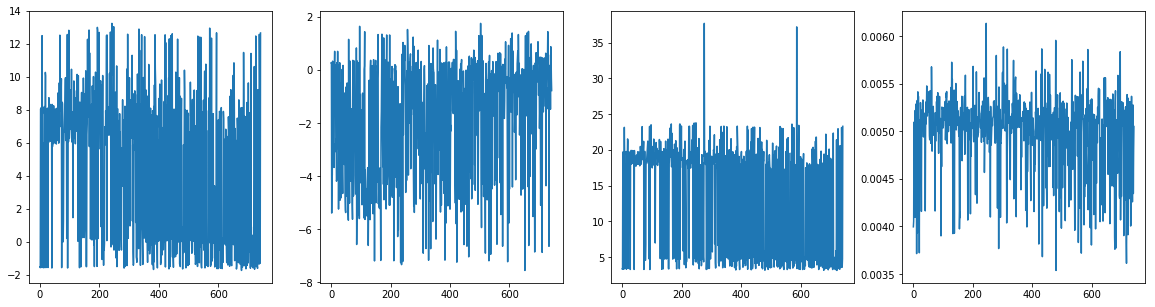

In [197]:
x,y,z=XS[0,:], XS[1,:], XS[2,:]
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(x)
plt.subplot(142)
plt.plot(y)
plt.subplot(143)
plt.plot(z)
plt.subplot(144)
plt.plot(err.flatten())
plt.show()

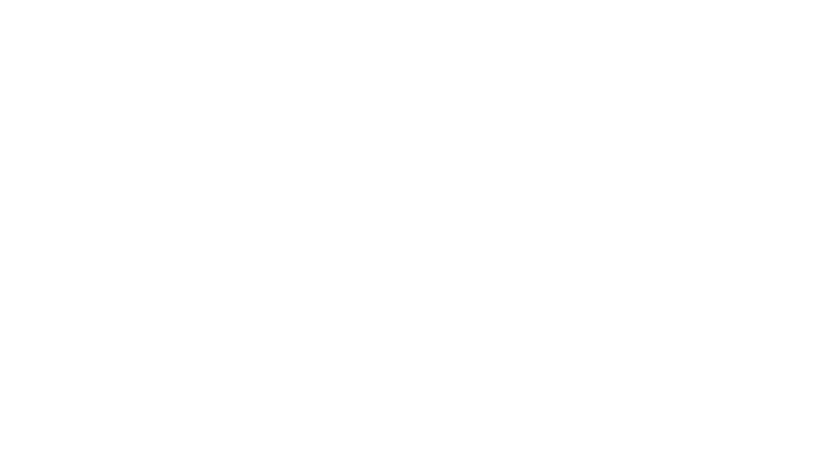

In [221]:
import plotly.graph_objects as go
x,y,z=XS[0,:], XS[1,:], XS[2,:]
fig = go.Figure(data=[go.Scatter3d(x=x, 
                                   y=y, 
                                   z=z,
                                   mode='markers',
                                   marker=dict(
                                       size=2))])
fig.show()

## bundle adjustment

### correspondence between 3D point, projection matrix, and 2D points

In [235]:
P1=np.eye(4)
P2=projection_matrix
inliers1=img1_calibrated_inliers[ind_inliers]
inliers2=img2_calibrated_inliers[ind_inliers]
XS,err=linearTriangulation(P1,inliers1,P2,inliers2)

In [236]:
XS[:,1]/XS[2,1]

array([-0.47060494,  0.07998033,  1.        ,  0.30193865])

In [237]:
inliers1[1,:]

array([-0.47062852,  0.08327666,  1.        ])

In [238]:
temp=np.dot(projection_matrix,XS)

In [239]:
temp[:,1]/temp[2,1]

array([-0.43364075,  0.11354374,  1.        ,  0.35403932])

In [240]:
inliers2[1,:]

array([-0.43366504,  0.10968613,  1.        ])

### recover rot_vec from rotation matrix

In [286]:
from scipy.spatial.transform import Rotation as R
r = R.from_dcm(np.array([
    [0, -1, 0],
    [1, 0, 0],
    [0, 0, 1]]))
rot_vec=r.as_rotvec()
print(rot_vec)
r=R.from_rotvec(rot_vec)
rotation_matrix=r.as_dcm()
print(rotation_matrix)

[0.         0.         1.57079633]
[[ 3.33066907e-16 -1.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  3.33066907e-16  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [247]:
from scipy.spatial.transform import Rotation as R
def proj_matrix_to_camera_vector(proj_mat):
    '''
    decompose the projection matrix to camera paras
    '''
    rot_mat=proj_mat[:3,:3]
    r=R.from_dcm(rot_mat)
    rot_vec=r.as_rotvec()
    t=proj_mat[:3,3]
    camera_vec=np.hstack((rot_vec,t))
    return camera_vec

In [248]:
proj_matrix_to_camera_vector(projection_matrix)

array([-0.024675  , -0.21222065,  0.00426862,  0.99692248, -0.01303617,
       -0.07730221])

### only optimize the rotation, translation and reconstruction

In [334]:
P1=np.eye(4)
P2=projection_matrix
inliers1=img1_calibrated_inliers[ind_inliers]
inliers2=img2_calibrated_inliers[ind_inliers]
XS,err=linearTriangulation(P1,inliers1,P2,inliers2)
print(XS.shape)
print(P1)
print(P2)

(4, 743)
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[ 0.97755768 -0.00162788 -0.21066163  0.99692248]
 [ 0.00684453  0.99968765  0.02403641 -0.01303617]
 [ 0.21055671 -0.02493886  0.97726349 -0.07730221]
 [ 0.          0.          0.          1.        ]]


In [284]:
# get camera params,  n_cameras x 6
n_cameras=2
camera_params=np.zeros((n_cameras,6))
camera_params[0,:]=proj_matrix_to_camera_vector(P1)
camera_params[1,:]=proj_matrix_to_camera_vector(P2)
print(camera_params.shape)

(2, 6)


In [282]:
# points_3d, n_points, 3
points_3d=XS[:3,:].T
print(points_3d.shape)

(743, 3)


In [291]:
# get camera_indice
n_cameras=2
n_points=pts_3d.shape[0]
camera_indices=[]
for i in range(n_cameras):
    camera_indices.extend([i]*n_points)
camera_indices=np.array(camera_indices)
print(camera_indices.shape)

(1486,)


In [293]:
# get point_ind
point_indices=[]
for i in range(n_cameras):
    for j in range(n_points):
        point_indices.append(j)
point_indices=np.array(point_indices)
print(point_indices.shape)

(1486,)


In [281]:
# get point_2d
pts_2d_1=inliers1[:,:2]
pts_2d_2=inliers2[:,:2]
pts_2d=np.vstack((pts_2d_1,pts_2d_2))
print(pts_2d.shape)

(1486, 2)


In [285]:
# get params
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))

In [287]:
def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.
    
    Rodrigues' rotation formula is used.
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis]
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    return cos_theta * points + sin_theta * np.cross(v, points) + dot * (1 - cos_theta) * v

In [309]:
def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""
    points_proj = rotate(points, camera_params[:, :3])
    points_proj += camera_params[:, 3:6]
    points_proj=points_proj[:, :2] / points_proj[:, 2, np.newaxis]
    return points_proj

In [310]:
# get residuals
n_cameras=2
n_points=points_3d.shape[0]
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    '''
    get residuals
    '''
    # recover cameras params and points 3d
    camera_params=params[:n_cameras*6].reshape((n_cameras,6))
    points_3d=params[n_cameras*6:].reshape((n_points,3))
    
    # reproject 3d points
    
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return (points_proj - points_2d).ravel()

In [311]:
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, pts_2d)

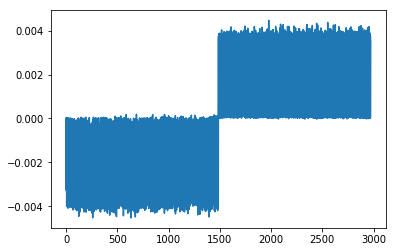

In [316]:
plt.plot(f0)

In [317]:
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = camera_indices.size * 2
    n = n_cameras * 6 + n_points * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 6 + s] = 1
        A[2 * i + 1, camera_indices * 6 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 6 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 6 + point_indices * 3 + s] = 1

    return A

In [320]:
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)

In [325]:
t0 = time.time()
res = least_squares(fun, x0,jac='3-point',jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, pts_2d))
t1 = time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0927e-02                                    2.93e+00    
       1              2         1.7357e-05      1.09e-02       2.60e+00       6.77e-03    
       2              3         1.7158e-05      1.99e-07       5.65e+00       7.43e-03    
       3              4         1.6779e-05      3.80e-07       1.69e-01       5.20e-07    
       4              5         1.6779e-05      5.15e-11       2.30e-02       6.93e-06    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 1.0927e-02, final cost 1.6779e-05, first-order optimality 6.93e-06.


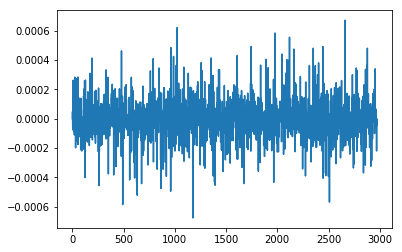

In [326]:
plt.plot(res.fun)

In [328]:
optimized_params=res.x

In [364]:
# # get new pts_3d
# points_3d=optimized_params[n_cameras*6:].reshape((n_points,3))

# x,y,z=points_3d[:,0], points_3d[:,1],points_3d[:,2]
# fig = go.Figure(data=[go.Scatter3d(x=x, 
#                                    y=y, 
#                                    z=z,
#                                    mode='markers',
#                                    marker=dict(
#                                        size=2))])
# fig.update_layout(width=800,height=800)
# fig.show()

In [332]:
def recover_projection_matrix(camera_param):
    rot_vec=camera_param[:3]
    translate_vec=camera_param[3:]
    r=R.from_rotvec(rot_vec)
    rot_matrix=r.as_dcm()
    P=np.eye(4)
    P[:3,:3]=rot_matrix
    P[:3,3]=translate_vec.T
    return P

In [333]:
# get new camera_paras
camera_params=optimized_params[:n_cameras*6].reshape((n_cameras,6))
P1=recover_projection_matrix(camera_params[0])
P2=recover_projection_matrix(camera_params[1])
print(P1)
print(P2)

[[ 9.99996343e-01 -2.53193852e-03  9.50642094e-04 -3.72475666e-02]
 [ 2.52887332e-03  9.99991644e-01  3.21182642e-03  8.30732424e-04]
 [-9.58766297e-04 -3.20941062e-03  9.99994390e-01  6.65839488e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 0.97701593 -0.00222027 -0.21315472  1.00664638]
 [ 0.0067729   0.99976423  0.02063045 -0.01536131]
 [ 0.21305866 -0.02159995  0.97680062 -0.01602157]
 [ 0.          0.          0.          1.        ]]


## P3P

### find next image

In [338]:
n_good_matches

array([[  0., 870., 834., 436.,  96., 147.,  95., 211., 140., 208., 336.],
       [846.,   0., 418., 273., 102.,  59.,  69., 160., 106., 256., 614.],
       [837., 391.,   0., 771.,  60.,  88., 133., 384., 238.,  88., 141.],
       [420., 192., 758.,   0.,  43., 108., 217., 717., 420.,  68.,  77.],
       [101., 104.,  79.,  59.,   0.,  68.,  75.,  62.,  72., 920., 250.],
       [ 75.,  46.,  73.,  80.,  36.,   0., 543., 129., 267.,  35.,  32.],
       [ 99.,  56., 123., 185.,  51., 528.,   0., 342., 706.,  49.,  39.],
       [196., 136., 385., 684.,  54., 173., 379.,   0., 724.,  58.,  64.],
       [118.,  68., 219., 350.,  43., 295., 788., 670.,   0.,  61.,  53.],
       [142., 232., 112.,  85., 943.,  59.,  71.,  57.,  82.,   0., 901.],
       [304., 582., 182., 127., 260.,  55.,  76.,  86.,  66., 925.,   0.]])

In [337]:
print(n_good_matches.shape)

(11, 11)


In [358]:
# initial query and train indice
query_indice=[ele.queryIdx for ele in good_match] # img1
train_indice=[ele.trainIdx for ele in good_match] # img2

# filter by ransacFundamental and decomposeE
query_indice=np.array(query_indice)
train_indice=np.array(train_indice)

mask_F=mask.ravel()==1
mask_E=ind_inliers
query_indice=query_indice[mask_F][mask_E]
train_indice=train_indice[mask_F][mask_E]

In [362]:
print(ind_img1,ind_img2)

9 4


In [361]:
# find next image with most overlapping 2D pts
img1_matches=good_matches[ind_img1]
n_overlaps=[]
ind_overlaps=[]
for match in img1_matches:
    ind_matches=[ele.queryIdx for ele in match]
    ind_overlap=[ele for ele in ind_matches if ele in query_indice ]
    n_overlap=len(ind_overlap)
    n_overlaps.append(n_overlap)
    ind_overlaps.append(ind_overlap)
n_overlaps=np.array(n_overlaps)
print(n_overlaps)

[ 32  64  30  20 743  12  11  13  18   0 205]


In [363]:
# find next image with most overlapping 2D pts
img2_matches=good_matches[ind_img2]
n_overlaps=[]
ind_overlaps=[]
for match in img2_matches:
    ind_matches=[ele.queryIdx for ele in match]
    ind_overlap=[ele for ele in ind_matches if ele in query_indice ]
    n_overlap=len(ind_overlap)
    n_overlaps.append(n_overlap)
    ind_overlaps.append(ind_overlap)
n_overlaps=np.array(n_overlaps)
print(n_overlaps)

[  9  17   9   8   0   9  10   6  11 143  31]


In [369]:
ind_img1=ind_img1
ind_img2=10

c_match=good_matches[ind_img1][ind_img2]
ind_new=[ele.trainIdx if ele.queryIdx in query_indice for ele in c_match]

new_pts_2d=[keypoints[ind_img2][ele] for ele ]